In [74]:
import sys
import os
os.environ['BACKEND'] = 'numpy'


import numpy as np
import pandas as pd 
import numba
from numba import njit, prange
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..', '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import get_global_logger, Array
from QES.general_python.common import Plotter, MatrixPrinter, colorsCycle, linestylesCycle
from QES.general_python.common import Directories
# from QES.general_python.common.hdf5_lib import HDF5Handler, read_hdf5_extract_and_concat_list
from QES.general_python.common.hdf5man import HDF5Manager
from QES.general_python.maths.statistics import HistogramAverage, Fraction

# ------------------------------------------------------------------
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.hilbert import HilbertSpace

# ------------------------------------------------------------------
from QES.Algebra.Properties import time_evo
from QES.Algebra.Properties import statistical
from QES.general_python.algebra.linalg import act, overlap, overlap_diag

# ------------------------------------------------------------------
import QES.Algebra.Operator.operators_spin as op_spin

logger      = get_global_logger()

# ------------------------------------------------------------------
data_dir = Directories(os.curdir, 'data_add')
data_dir.mkdir()


Directories(PosixPath('data_add'))

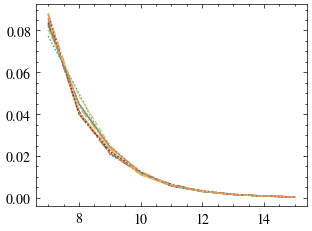

In [72]:
rng                 = np.random.default_rng()
rand_num            = rng.integers(0, int(1e5))

bw_df               = pd.read_csv("bw.csv", index_col=0, header=None, dtype=float)
mls_df              = pd.read_csv("mls.csv", index_col=0, header=None, dtype=float)
bw_df.index         = [f'{x:.2f}' for x in bw_df.index]
mls_df.index        = [f'{x:.2f}' for x in mls_df.index]
bw_df.columns       = list(range(7, 17))
mls_df.columns      = list(range(7, 16))

for i in range(len(bw_df.columns)):
    mls_df.iloc[i].plot(label=f'{bw_df.index[i]}', linestyle=next(linestylesCycle))


In [169]:

@njit(fastmath=True)
def k_function(ldos     :   np.ndarray,
            energies    :   np.ndarray,
            bins        :   np.ndarray):
    """
    Compute 
        k(ω) = ∑_{i≤j}  ldos[i]·ldos[j] · δ(ω - |E[j]-E[i]|)
    using a histogram binning method.
    
    Parameters
    ----------
    ldos : float64[:]
        Local density of states (LDOS) at each energy level.
    energies : float64[:]
        Energies of the system.
    bins : float64[:]
        Bins for histogramming the energy differences.
    """
    nE   = energies.shape[0]
    nbin = bins.shape[0] - 1         # bins defines edges, length = nbins+1
    kf   = np.zeros(nbin, ldos.dtype)
    cnt  = np.zeros(nbin, np.int64)

    for i in range(nE):
        ei = energies[i]
        li = ldos[i]
        for j in range(i, nE):
            # absolute energy difference
            dE      = ei - energies[j]
            omega   = dE if dE >= 0.0 else -dE

            # find bin index: largest b such that bins[b] ≤ omega
            # searchsorted returns insertion point in bins to keep sorted
            idx     = np.searchsorted(bins, omega, side='right') - 1

            # clamp to valid range [0, nbin−1]
            if idx < 0:
                idx = 0
            elif idx >= nbin:
                idx = nbin - 1

            kf[idx]  += li * ldos[j]
            cnt[idx] += 1

    return kf, cnt


def remove_moving_average(data: np.ndarray, window: int) -> np.ndarray:
    """
    Subtract from each row of `data` its causal moving average of length `window`.

    Let
      data[i, t] ∈ ℝ,
    and define the cumulative sum for each row:
      C[i, t] = ∑_{k=0}^t data[i, k].
    Then the causal moving average is
      m[i, t] = 
         C[i, t] / (t+1),        for t < window,
        (C[i, t] − C[i, t−window]) / window,  otherwise.
    We return
      residual[i, t] = data[i, t] − m[i, t].

    Parameters
    ----------
    data : np.ndarray, shape (N, T)
        N realizations (rows) of length-T time series.
    window : int
        Width of the causal moving‐average window.

    Returns
    -------
    residual : np.ndarray, shape (N, T)
        Original data with its moving average removed, per row.
    """
    N, T      = data.shape
    cumsum    = np.cumsum(data, axis=1)      # shape (N, T)
    residual  = np.empty_like(data, dtype=float)

    # first `window` points use growing denominator (1,2,…,window)
    t0        = min(window, T)
    counts    = np.arange(1, t0+1)           # [1, 2, …, t0]
    residual[:, :t0] = data[:, :t0] - cumsum[:, :t0] / counts

    # remaining points use fixed window
    if T > window:
        numer = cumsum[:, window:] - cumsum[:, :-window]
        ma    = numer / window
        residual[:, window:] = data[:, window:] - ma

    return residual

In [180]:
import matplotlib.pyplot as plt

def get_results_single(direct   : Directories, 
                        alpha   : float,
                        ns      : int,
                        n       : int,
                        uniform : bool = False,
                        operator: str  = 'Sz/0'
                        ):
    fig, ax         = Plotter.get_subplots(nrows = 1, ncols = 3, figsize = (12, 4), dpi = 100)
    fig.suptitle(f"$\\alpha={alpha:.2f}, L={ns-n}$")
    
    Plotter.set_ax_params(ax[0], xlabel=r'$\omega$', ylabel=r'$\tilde{S}(\omega)$', xscale='log', yscale='log')
    Plotter.set_ax_params(ax[1], xlabel=r'$t$', ylabel=r'$Q(t)$', xscale='log', yscale='log')
    # Plotter.set_ax_params(ax[2], xlabel=r'$\omega$', ylabel=r'$K(\omega)$', xscale='log', yscale='log')
    
    
    hist_key        = f'/historgram/{operator}/average/values'
    hist_typ_key    = f'/historgram/{operator}/typical/values'
    hist_count_key  = '/historgram/counts'
    hist_edges_key  = '/historgram/edges'
    energy_key      = '/energies'
    ldos_key        = '/ldos'
    time_key        = '/time'
    time_evo_key    = f'/time_evolution/{operator}/expectation'
    hilbert_dim     = 2**ns
    #! -------------------------------------------------------
    model = UltrametricModel(
        ns      = ns,
        n       = n,
        alphas  = alpha
    )
    direct_in   = Directories(os.path.abspath(direct), 'uniform' if uniform else 'log', str(model))
    filelist    = direct_in.list_files(filters = [lambda x: str(x).endswith('h5')])
    if len(filelist) == 0:
        logger.warning(f"Files not found in {direct_in}")
        return None

    filelist        = [str(x) for x in filelist]
    filelist_stat   = [x for x in filelist if 'stat_' in x  ]
    filelist_evo    = [x for x in filelist if 'evo_'  in x  ]
    filelist_diag   = [x for x in filelist if 'dia_'  in x  ]
    filelist_hist   = [x for x in filelist if 'hist_' in x  ]
    
    # --------------------------------------------------------
    #! histogram
    data_hist_av    = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_key])
    data_hist_av    = np.mean([x[hist_key] for x in data_hist_av], axis=0)
    data_hist_typ   = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_typ_key])
    data_hist_typ   = np.mean([x[hist_typ_key] for x in data_hist_typ], axis=0)
    data_hist_bins  = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_edges_key])
    data_hist_bins  = np.mean([x[hist_edges_key] for x in data_hist_bins], axis=0)
    data_hist_count = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_count_key])
    data_hist_count = np.mean([x[hist_count_key] for x in data_hist_count], axis=0)

    # --------------------------------------------------------
    #! time evolution
    data_evo_av     = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_evo, dataset_keys=[time_evo_key])
    data_evo_av     = np.array([x[time_evo_key] for x in data_evo_av])
    data_evo_av     = data_evo_av.reshape((np.prod(data_evo_av.shape[:-1]), data_evo_av.shape[-1]))
    # remove structure
    # data_evo_av     = remove_moving_average(data_evo_av, window=31)
    
    bandwidth_data  = bw_df.loc[f'{alpha:.2f}', ns]
    time_delta      = 2.0 * np.pi / bandwidth_data
    time_num        = data_evo_av.shape[1]
    data_evo_fft_om = np.fft.fftfreq(time_num, d=time_delta)[1:time_num//2]
    data_evo_fft    = np.fft.fft(data_evo_av, axis=1)[:, 1:time_num//2]
    data_evo_fft    = np.abs(data_evo_fft)**2
    # data_evo_fft_n  = np.trapz(data_evo_fft, x=data_evo_fft_om, axis=1)
    # data_evo_fft    = np.mean(data_evo_fft.T / data_evo_fft_n, axis=1)
    data_evo_fft    = np.mean(data_evo_fft, axis=0)
    
    print(f"bandwidth: {bandwidth_data}, time delta: {time_delta}, time num: {time_num}, shape: {data_evo_fft_om.shape}")
    print(f"data_evo_fft shape: {data_evo_fft.shape}")
    
    data_evo_time   = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_evo, dataset_keys=[time_key])
    data_evo_time   = np.array([x[time_key] for x in data_evo_time])[0]
    Plotter.plot(ax[1], data_evo_time, np.mean(data_evo_av, axis = 0) + 1, label=r'$\tilde{C}(t) + 1$', ls=next(linestylesCycle), color = 'blue')
    Plotter.plot(ax[0], data_evo_fft_om, data_evo_fft, label=r'$\tilde{S}(\omega)$', ls=next(linestylesCycle), color = 'blue')
    
    # --------------------------------------------------------
    #! energy
    data_energy     = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_stat, dataset_keys=['/energies'])
    data_energy     = np.array([x[energy_key] for x in data_energy])
    data_energy     = data_energy.reshape((np.prod(data_energy.shape[:-1]), data_energy.shape[-1]))
    data_ldos       = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_stat, dataset_keys=['/ldos'])
    data_ldos       = np.array([x[ldos_key] for x in data_ldos])
    data_ldos       = data_ldos.reshape((np.prod(data_ldos.shape[:-1]), data_ldos.shape[-1]))
    
    k_function_list         = [k_function(data_ldos[i], data_energy[i], data_hist_bins) for i in range(len(data_energy))]
    k_functions             = np.array([x[0] for x in k_function_list]).sum(axis=0)
    k_counts                = np.array([x[1] for x in k_function_list]).sum(axis=0)
    k_counts[k_counts == 0] = 1
    k_functions            /= k_counts
    ax[0].stairs(k_functions * hilbert_dim, data_hist_bins, label=r'$K(\omega) \mathcal{D}$', linestyle=next(linestylesCycle), color = 'black')
    ax[0].stairs(data_hist_av[1:] * hilbert_dim, data_hist_bins, label=r'$|O_{nm}|^2 \mathcal{D}$', ls=next(linestylesCycle), color = 'red')
    
    #! -------------------------------------------------------
    # join all data
    
    # data_out = {
    #     'f_functions_av' : data_hist[f'histogram/{operator}/average/values'],
    #     'f_functions_tp' : data_hist[f'histogram/{operator}/typical/values'],
    #     'counts'         : data_hist[f'histogram/counts'],
        
        
    # }

    #! -------------------------------------------------------
    for axis in ax:
        Plotter.set_legend(axis)
        Plotter.set_tickparams(axis)
        axis.grid()
    fig.tight_layout()

bandwidth: 12.81071543, time delta: 0.49046326425030784, time num: 40000, shape: (19999,)
data_evo_fft shape: (19999,)
bandwidth: 13.70339747, time delta: 0.45851295789492896, time num: 40000, shape: (19999,)
data_evo_fft shape: (19999,)
bandwidth: 13.34988251, time delta: 0.47065472692160687, time num: 40000, shape: (19999,)
data_evo_fft shape: (19999,)
bandwidth: 14.69583239, time delta: 0.42754878665158663, time num: 40000, shape: (19999,)
data_evo_fft shape: (19999,)


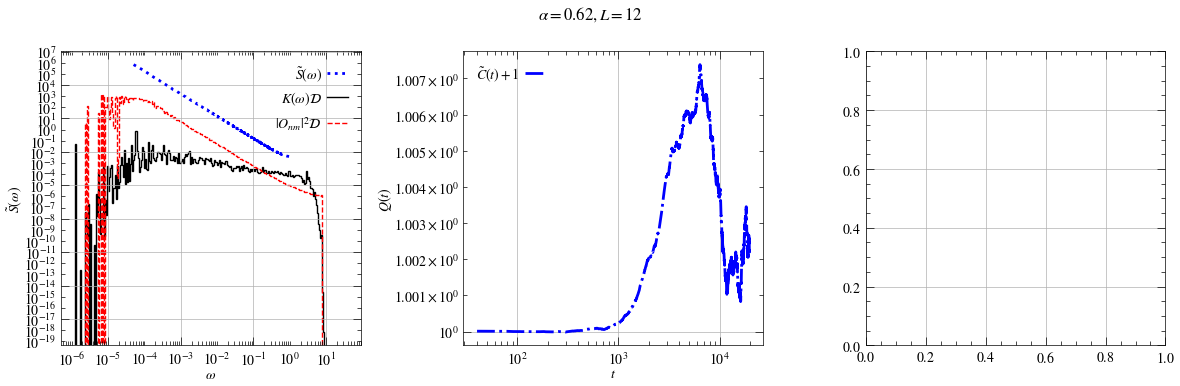

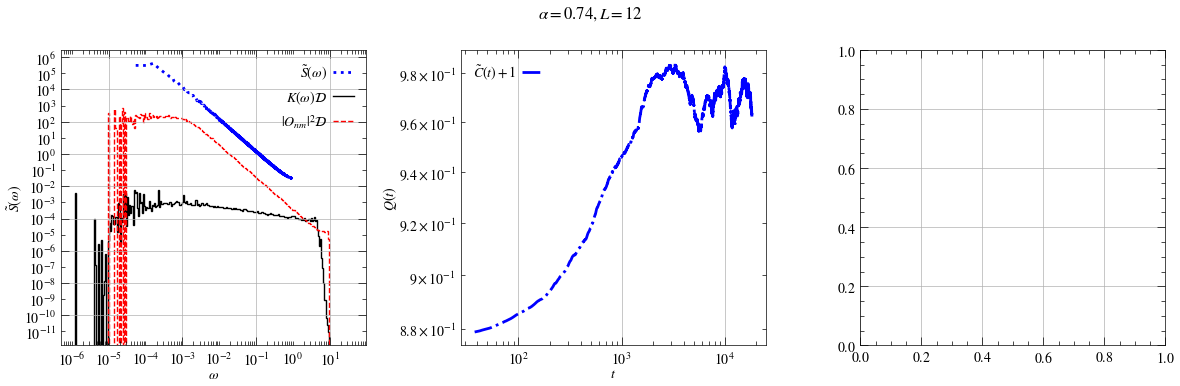

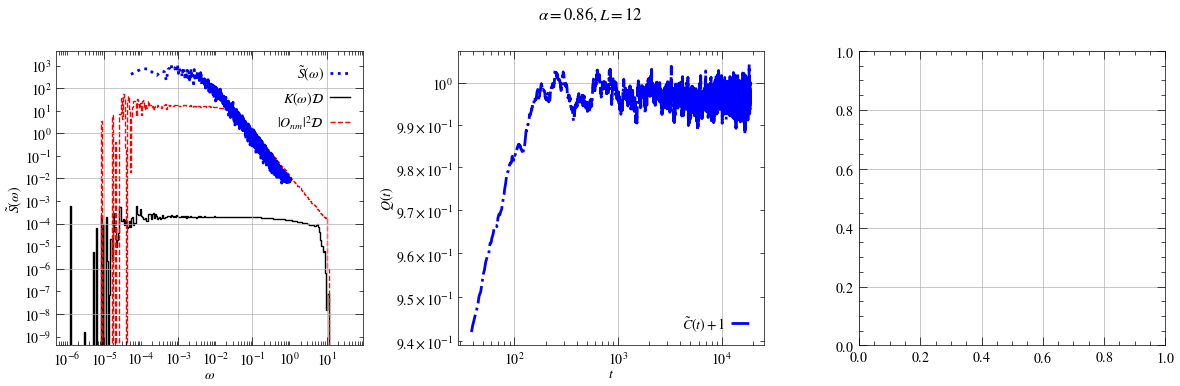

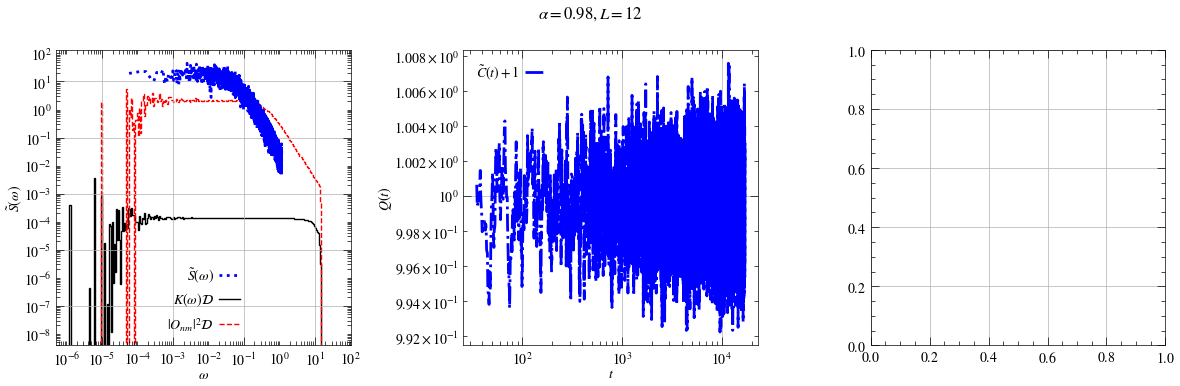

In [182]:
alphas          = np.arange(0.62, 1.0, 0.12)
sites           = np.arange(13, 14, dtype=int)
n               = 1
for alpha in alphas:
    for ns in sites:
        y = get_results_single(
            direct   = data_dir,
            alpha    = alpha,
            ns       = ns,
            n        = n,
            uniform  = True
        )
y